In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from   sklearn.linear_model import LinearRegression, LogisticRegression
from   sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [260]:
shark_data = pd.read_excel("shark_attack_data_cleaned.xlsx", nrows = 1198)

C:\Users\pedro\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:211: UserWarning: Cell A1048576 is marked as a date but the serial value 14707374 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)


In [261]:
shark_data.Date = pd.to_datetime(shark_data.Date)

In [262]:
shark_data = shark_data.sort_values(by = "Date", ascending = False)
shark_data.reset_index(inplace=True)
shark_data.drop(columns = ["index", "Time"])

,Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Fatal,Species
0,2018-06-25,2018,Boating,USA,California,"Oceanside, San Diego County",Board involved,F,57,0,White
1,2018-05-26,2018,Unprovoked,USA,Florida,"Cocoa Beach, Brevard County",Swimming/Diving,M,15,0,Bull
2,2018-05-24,2018,Provoked,AUSTRALIA,Queensland,Cairns Aquarium,Shark involved,M,32,0,Grey reef
3,2018-04-25,2018,Unprovoked,AUSTRALIA,Western Australia,"Surfers Point, Prevelly",Board involved,M,60,0,Unidentified species
4,2018-04-22,2018,Unprovoked,SOUTH AFRICA,Western Cape Province,"Robberg Beach, Plettenberg Bay",Board involved,M,33,0,White
...,...,...,...,...,...,...,...,...,...,...,...
1193,1905-03-26,1905,Unprovoked,AUSTRALIA,New South Wales,Lismore,Swimming/Diving,M,40,0,Unidentified species
1194,1901-07-30,1901,Unprovoked,SOUTH AFRICA,Western Cape Province,Windmill Beach,Swimming/Diving,M,29,1,White
1195,1894-11-28,1894,Unprovoked,AUSTRALIA,New South Wales,Newcastle,Swimming/Diving,M,19,0,Unidentified species
1196,1892-03-02,1892,Provoked,AUSTRALIA,New South Wales,Lake Macquarie,Fishing,M,21,0,Unidentified species


In [263]:
shark_data_c = shark_data.loc[shark_data.Species != "Unidentified species"]

In [264]:
shark_data_clean = shark_data_c.drop(["Date", "Year", "Location", "index", "Time"], axis = 1)

In [265]:
print(f"In order to eventually perform a logistic regression analysis I will only be looking at attacks where the shark can be identified. \
In {len(shark_data_c)/len(shark_data) *100:.02f}% of shark attaks the shark could not be identified.") 

In order to eventually perform a logistic regression analysis I will only be looking at attacks where the shark can be identified. In 62.10% of shark attaks the shark could not be identified.


## Some preliminary data exploration

Sex
F     157
M    1041
Name: Sex, dtype: int64
Attacks on Males number 1041 while females number 156. 86.89% male and 13.02% female.


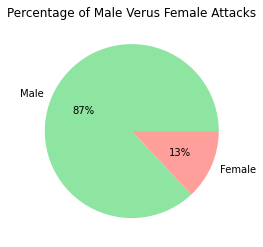

In [266]:
print(shark_data.groupby("Sex")["Sex"].count())
print(f"Attacks on Males number 1041 while females number 156. {1041/len(shark_data)* 100 :.2f}% male and{156/len(shark_data)* 100 : .2f}% female.")

percent_male = 86.82
percent_female = 13.01
data = [percent_male, percent_female]
labels = ["Male", "Female"]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[2:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Percentage of Male Verus Female Attacks")
plt.show()

Text(0.5, 1.0, 'Number of Shark Attacks By Shark Species')

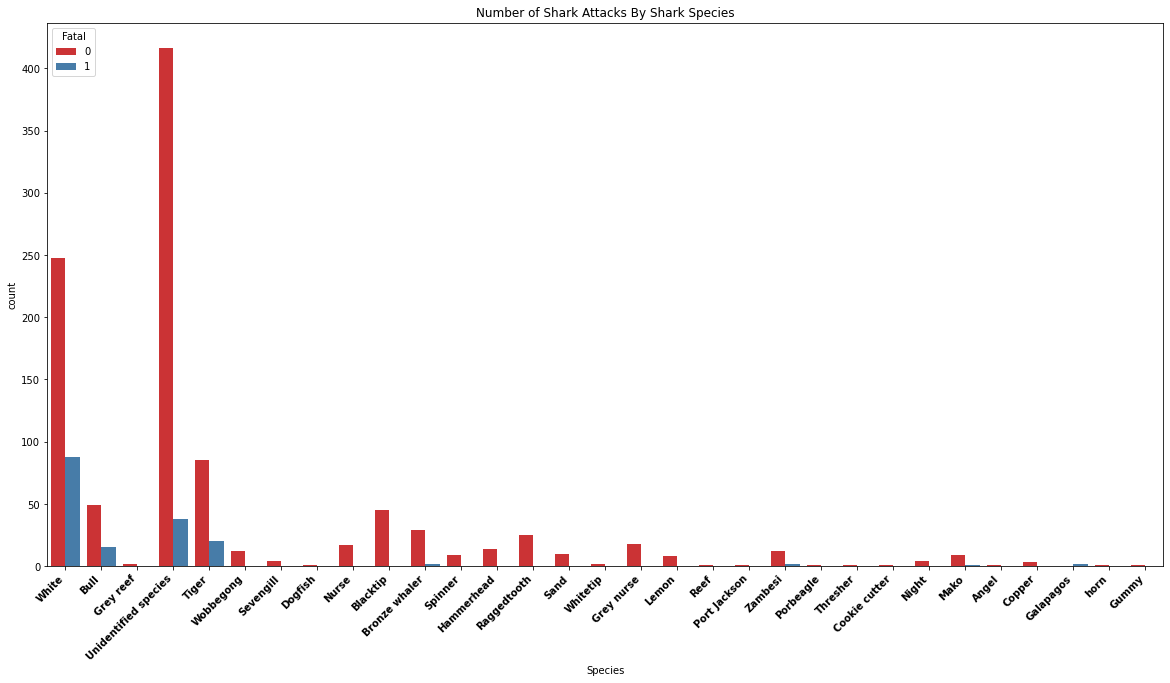

In [267]:
plt.figure(figsize=(20,10))

# draw the chart
chart = sns.countplot(
    data=shark_data_clean.sort_values(by = "Species", ascending = True), x = shark_data.Species,
    palette='Set1', hue = shark_data.Fatal, 
)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='heavy',
    fontsize='medium'
    
)

plt.title("Number of Shark Attacks By Shark Species")

Text(0.5, 0, 'Attacks by country divided by fatality')

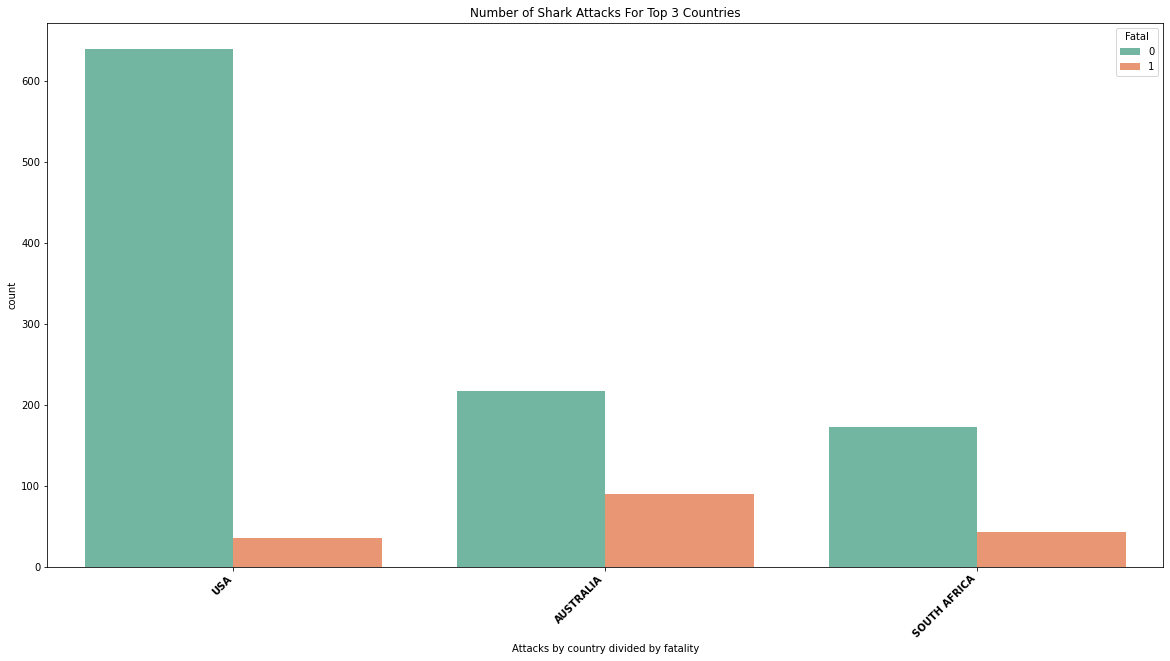

In [268]:
# set the figure size
plt.figure(figsize=(20,10))

# draw the chart
chart = sns.countplot(
    data=shark_data_clean, x = shark_data.Country,
    palette='Set2', hue = shark_data.Fatal, 
)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='heavy',
    fontsize='medium'
    
)

plt.title("Number of Shark Attacks For Top 3 Countries")
plt.xlabel("Attacks by country divided by fatality")

## Calculating Base-line Score (What percent of sharks attacks are fatal?)

In [269]:
base_line = shark_data.loc[shark_data['Fatal'] == 1]

print(f"Fatal: {len(base_line)/ len(shark_data) * 100:.02f}%", f" Not Fatal {(1- len(base_line)/ len(shark_data))* 100:.02f}%")
print(f"The baseline score to beat is 86%. In other words if we guessed none-fatal everytime we would be right 86% of the time.")

Fatal: 14.02%  Not Fatal 85.98%
The baseline score to beat is 86%. In other words if we guessed none-fatal everytime we would be right 86% of the time.


## Fitting and training Logistic Rergression model

In [270]:


raw_features = shark_data_clean[['Activity','Sex','Species', "Type", "Country"]]

features = pd.get_dummies(raw_features)

target = shark_data_clean['Fatal']

model = LogisticRegression()

known_input, future_input, known_output, future_output = train_test_split(features, target, test_size=0.2, random_state=42)

model.fit(known_input, known_output) # tell it known stuff

predictions = model.predict(future_input) # given future input, predict future output!


## Printing the Cross Validated Score 

In [271]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=5).fit(known_input, known_output)
print(f"The 5-fold crossvalidated score of my logistic regression model. {clf.score(future_input, future_output):.04}")

The 5-fold crossvalidated score of my logistic regression model. 0.8591


## Comapring Different Model Performance

In [272]:
# Here I subset the data and only printed the columns I will be using for my analysis
shark_data_clean.sample(5)

,Type,Country,Area,Activity,Sex,Age,Fatal,Species
1183,Unprovoked,AUSTRALIA,New South Wales,Swimming/Diving,M,18,1,White
525,Unprovoked,SOUTH AFRICA,Western Cape Province,Swimming/Diving,M,25,0,White
947,Unprovoked,USA,California,Swimming/Diving,M,45,0,White
650,Unprovoked,USA,California,Board involved,M,16,0,White
242,Unprovoked,USA,Florida,Fishing,M,21,0,Bull


In [273]:

# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(), 
    'Tree': DecisionTreeClassifier(),
    'Bayes': MultinomialNB()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        features, # feature matrix
        target, # gold labels
        cv=10, #number of folds
        scoring=['accuracy', 'recall', 'f1'] # scoring methods
    )

In [274]:
# Examine the performance of our simple classifiers

def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [275]:
# Compare cross-validation scores

compare_scores(scores)

,fit_time,score_time,test_accuracy,test_recall,test_f1
kNN,0.005446,0.013754,0.830685,0.323077,0.391870
Logit,0.027753,0.008829,0.832036,0.261538,0.320150
Tree,0.005997,0.007273,0.830649,0.300000,0.364834
Bayes,0.006342,0.007593,0.836090,0.215385,0.293951


## Brief Discussion and next Steps

When I first began this analysis I was under the impression that predicting fatal versus non-fatal attacks would be a perfect task for a machine learning model. The data for all recorded shark attacks since 1865 was made available through the work of shark scientists and the NSF thus I believed this to be a straightforward and very informative analysis. However, after looking at the data provided I notice that the dataset was updated over the years with very inconsistent and rather uninformative information. A lot of the data entries were filled with superfluous data that did not add any substantive information to the report. So some time and care were taken in cleaning this data using both excel and some quick pandas commands. 

However, after cleaning the data I thought that predicting a binary variable like fatal or non-fatal would be perfect for a logistic regression model which shines in instances like these. To predict fatal or non-fatal attacks I decided to use features such as what activities were being performed during the attack, the biological sex of the victim, the country where the attack occurred, the type of attack that occurred (provoked, unprovoked, boat disaster), and the age of the victim, and finally if the information was available the species of shark that attacked the victim. This last feature was particularly difficult to incorporate since many of the entries had an unidentified shark as being responsible. I decided to not include these in the final analysis. 

One thing to note is that the baseline score for fatal shark attacks is particularly high. In fact, for 86% of shark attack cases, the result is a non-fatal encounter. This made trying to beat the baseline score particularly difficult. After fitting the logistic regression model I was only able to get an accuracy of about baseline from my model.

After not getting the output I wanted I tried using different classifiers but none of them gave me the accuracy or f1 score I was hoping for. What does this mean? Probably that I am not fitting the models with the right data or that I do not have the right parameters for my model. But more broadly it might be because shark attacks are on average very random and the fatality rate of a shark attack victim is mostly out of their control. 